# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**--------------------------------------------------------------------**

**Identifying the key drivers for used car prices is useful from a business standpoint because it allows for effective inventory management. A car's likely sale price is one element needed for projecting the _profit_ likely to be made from selling it, and that information allows for profit-maximizing inventory decisions.**  

**To identify the key driverse for used car prices, we need data from a representative sample of used car purchases. This data should include the purchase price along with information about a variety of potentially relevant features of the cars purchased. With this information in hand, we can try out different predictive models with the purchase price as the target - that is, different ways of mathematically combining information about the various features of a car so as to generate a prediction of that car's price. Once we have a model (or collection of models) that works well, we can examine it further to see which features are playing the largest roles. A feature that plays a large role in a successful predictive model will be a good candidate, at least, for being a key driver of used car prices, and practical recommendations can be made on that basis. (It is important to note, however, that "key driver" is a causal notion, and features can be useful for predicting the output of a process without actually playing much/any causal role in that process.)**  

**--------------------------------------------------------------------**

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

**--------------------------------------------------------------------**

**After importing the dataset, we can begin by running .info() to get some basic information - the column headings, the number of non-null entries in each column, and the data type for each column - and .sample() to see some sample entries.**

**It can be seen from that initial inspection that several columns contain categorical data (e.g. manufacturer, fuel, etc.) or ordinal data (e.g. condition). We can use .unique() to see what values appear in each of those columns, which will be helpful when deciding in the future whether/how to incorporate that data into our model (e.g. via one-hot or ordinal encoding).** 

**Finally, it is useful to look at the range of prices that appear in the dataset by sorting values (both ascending and descending) and looking at the top results. This can reveal various faulty entries, i.e. numbers that aren't realistic used car prices (perhaps because they are something else entirely, like a phone number, or just a placeholder like 12345678).**

**--------------------------------------------------------------------**

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.inspection import permutation_importance

In [3]:
df = pd.read_csv('vehicles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
df.sample(10)

id                 region  price    year   manufacturer  \
230285  7313174869              asheville  15500  2007.0  mercedes-benz   
149514  7310403920           st louis, MO   9988  2014.0            kia   
287931  7305779677         akron / canton   6500  2010.0          dodge   
19498   7314439241            little rock  39864  2017.0  mercedes-benz   
40888   7302904222           monterey bay   7500  2006.0         toyota   
176949  7305891307            new orleans  14495  2018.0        hyundai   
126912  7308299616  savannah / hinesville   5700  2006.0           ford   
372761  7308648886                el paso  36590  2019.0            gmc   
135288  7314806651       pullman / moscow  34999  2015.0         toyota   
169437  7311306315                wichita  12598  2014.0           ford   

                             model  condition    cylinders fuel  odometer  \
230285            benz e350 4matic  excellent  6 cylinders  gas   50401.0   
149514                        soul  excellent  4 cylinders  gas   78000.0   
287931                  charger se  excellent  6 cylinders  gas  122000.0   
19498                          glc        NaN          NaN  gas   36358.0   
40888               avalon limited  excellent  6 cylinders  gas  161715.0   
176949                      sonata   like new  4 cylinders  gas  103511.0   
126912                explorer xlt  excellent  6 cylinders  gas  177000.0   
372761  sierra 1500 limited double       good  8 cylinders  gas   14222.0   
135288     tundra sr5 4x4 half ton        NaN          NaN  gas   83867.0   
169437                      escape        NaN          NaN  gas  116652.0   

       title_status transmission                VIN drive       size    type  \
230285        clean    automatic                NaN   NaN   mid-size   sedan   
149514          NaN    automatic  KNDJP3A51E7017187   NaN        NaN   wagon   
287931        clean    automatic  2B3CA4CD8AH224132   rwd  full-size   sedan   
19498         clean    automatic                NaN   NaN        NaN     NaN   
40888           NaN    automatic  4T1BK36B56U110942   NaN        NaN   other   
176949        clean    automatic                NaN   NaN        NaN     NaN   
126912        clean    automatic                NaN   rwd        NaN     SUV   
372761        clean        other  2GTV2LECXK1123316   4wd        NaN  pickup   
135288        clean    automatic  5TFUY5F18FX424470   4wd        NaN   truck   
169437        clean    automatic  1FMCU0F70EUB00472   fwd        NaN     NaN   

       paint_color state  
230285         NaN    nc  
149514         NaN    il  
287931         red    oh  
19498          NaN    ar  
40888          NaN    ca  
176949        grey    la  
126912       white    ga  
372761        blue    tx  
135288       black    id  
169437         NaN    ks

In [5]:
print('Manufacturers: ', df['manufacturer'].unique(),'\n')
print('Condition: ', df['condition'].unique(),'\n')
print('Cylinders: ', df['cylinders'].unique(),'\n')
print('Fuel type: ', df['fuel'].unique(),'\n')
print('Title Status: ', df['title_status'].unique(),'\n')
print('Transmission: ', df['transmission'].unique(),'\n')
print('Drive: ', df['drive'].unique(),'\n')
print('Type: ', df['type'].unique(),'\n')
print('Color: ', df['paint_color'].unique(),'\n')
print('State: ', df['state'].unique())

Manufacturers:  [nan 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln' 'alfa-romeo' 'subaru' 'acura' 'hyundai'
 'mercedes-benz' 'bmw' 'mitsubishi' 'volkswagen' 'porsche' 'kia' 'rover'
 'ferrari' 'mini' 'pontiac' 'fiat' 'tesla' 'saturn' 'mercury'
 'harley-davidson' 'datsun' 'aston-martin' 'land rover' 'morgan'] 

Condition:  [nan 'good' 'excellent' 'fair' 'like new' 'new' 'salvage'] 

Cylinders:  [nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders'] 

Fuel type:  [nan 'gas' 'other' 'diesel' 'hybrid' 'electric'] 

Title Status:  [nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only'] 

Transmission:  [nan 'other' 'automatic' 'manual'] 

Drive:  [nan 'rwd' '4wd' 'fwd'] 

Type:  [nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon'] 

Color:  [

In [6]:
df['price'].sort_values(ascending=False).head(15)

318592    3736928711
356716    3736928711
257840    3024942282
91576     3024942282
37410     3009548743
184704    1410065407
153082    1234567890
29386     1111111111
37409     1111111111
122470     987654321
280        987654321
230753     135008900
193736     123456789
288356     123456789
307488     123456789
Name: price, dtype: int64

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [7]:
# Drop all rows with NaN in either the year column or the odometer column (since these are of fundamental importance) 
df = df.dropna(subset=['year','odometer'])

In [8]:
# Replace NaN with 'unknown' in columns with categorical data
df[['manufacturer','cylinders','fuel','title_status','transmission','drive','type','paint_color']] = df[[
    'manufacturer','cylinders','fuel','title_status','transmission','drive','type','paint_color']].fillna('unknown')

In [9]:
# Drop columns that are irrelevant, missing too much data, or too fine-grained to be usable
df = df.drop(['id','region','model','VIN','size','state'],axis=1)

In [10]:
# Replace NaN with the most common value - in this case, also an intermediate value - in the ordinal 'condition' column
df[['condition']] = df[['condition']].fillna('good')

In [11]:
# Change year and odometer entries from floats to integers
df['year'] = df['year'].astype(int)
df['odometer'] = df['odometer'].astype(int)

In [12]:
# Drop rows with faulty/unrealistic prices
placeholders = [11111,12345,99999]
df = df[(df['price']<100_000)&(df['price']>500)&~(df['price'].isin(placeholders))]

<AxesSubplot: title={'center': 'Used Car Prices'}, xlabel='price', ylabel='Count'>

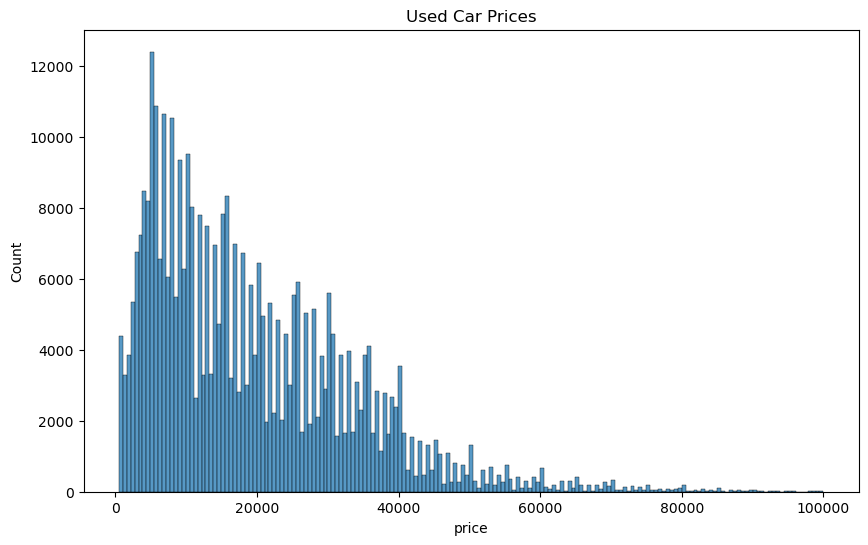

In [13]:
# See the distribution of prices after cleaning
plt.figure(figsize=(10,6))
plt.title('Used Car Prices')
sns.histplot(df['price'])

<AxesSubplot: title={'center': 'Price by Manufacturer'}, xlabel='manufacturer', ylabel='price'>

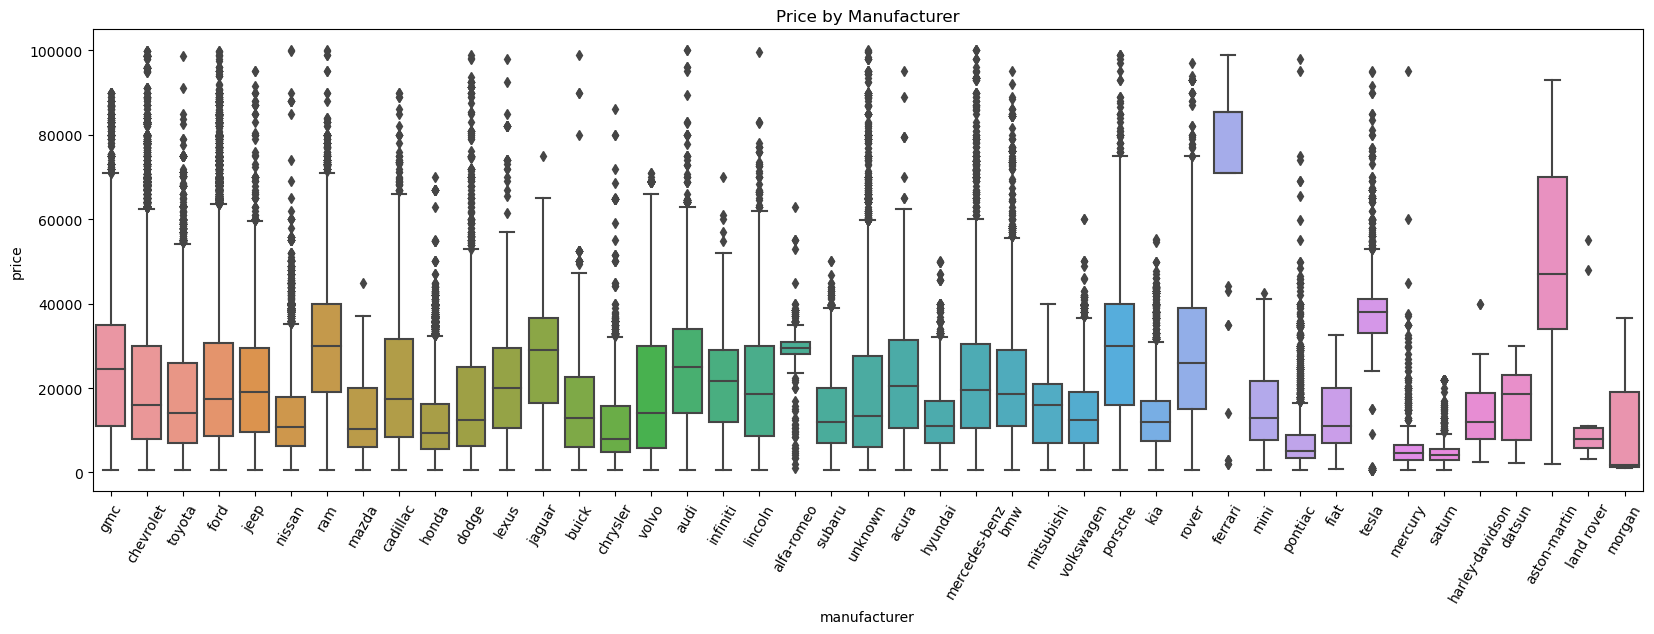

In [14]:
# See whether any useful info can be practically extracted from the 'manufacturer' column
plt.figure(figsize=(20,6))
plt.title('Price by Manufacturer')
plt.xticks(rotation=60)
sns.boxplot(data=df, x=df['manufacturer'],y=df['price'])

In [15]:
# In light of the above, convert manufacturer to 0/1 scale (high-grade vs. standard)
high_grade = ['ferrari','aston-martin','ram','porsche','rover','tesla','jaguar','alfa-romeo']
standard = list(df.query('manufacturer not in @high_grade')['manufacturer'].unique())

df['manufacturer'] = df['manufacturer'].replace(standard,0).replace(high_grade,1)

<AxesSubplot: title={'center': 'Price by Number of Cylinders'}, xlabel='cylinders', ylabel='price'>

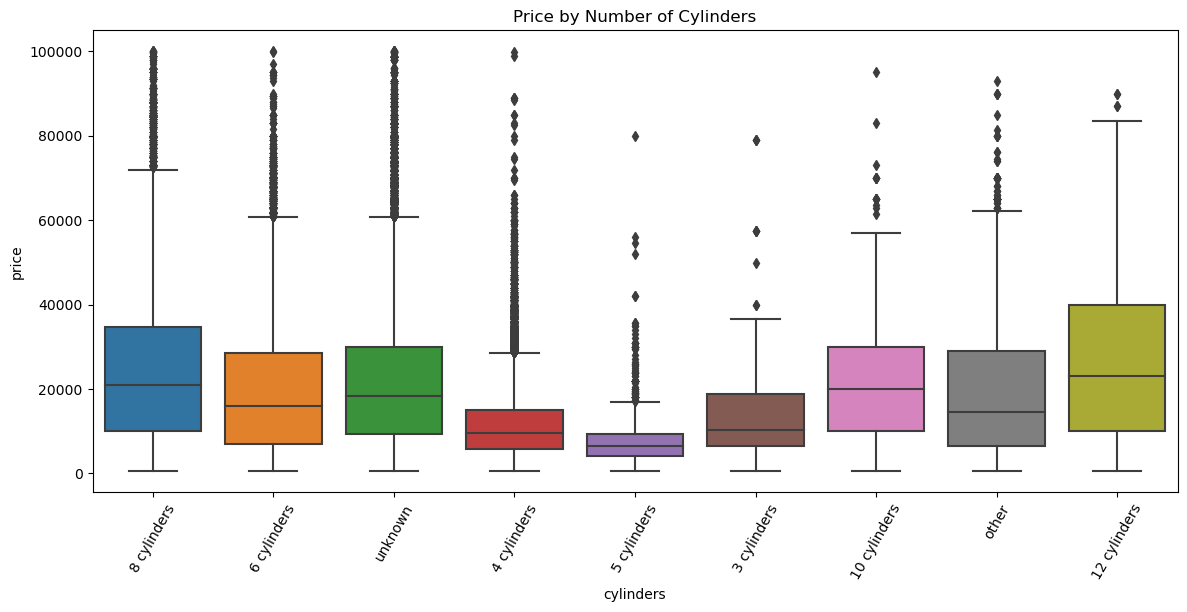

In [16]:
# See whether any useful info can be practically extracted from the 'cylinders' column
plt.figure(figsize=(14,6))
plt.title('Price by Number of Cylinders')
plt.xticks(rotation=60)
sns.boxplot(data=df, x=df['cylinders'],y=df['price'])

In [17]:
# Convert number of cylinders to integers (since the relationship appears to be linear or at least monotonic)
df = df.replace({'cylinders': {'3 cylinders':3,'4 cylinders':4,'5 cylinders':5,'6 cylinders':6,'8 cylinders':8,
                              '10 cylinders':10,'12 cylinders':12,'other':6,'unknown':6}})

<AxesSubplot: title={'center': 'Price by Title Status'}, xlabel='title_status', ylabel='price'>

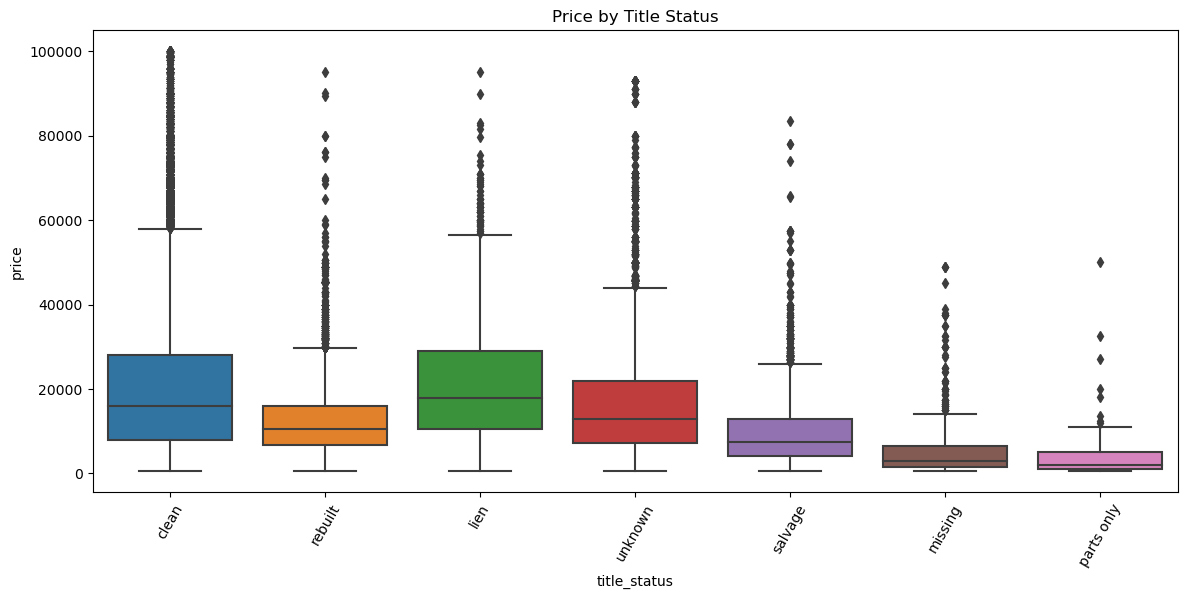

In [18]:
# See whether any useful info can be practically extracted from the 'title_status' column
plt.figure(figsize=(14,6))
plt.title('Price by Title Status')
plt.xticks(rotation=60)
sns.boxplot(data=df, x=df['title_status'],y=df['price'])

In [19]:
# In light of the above, convert title status to 0/1 scale ('good' vs. 'bad' title)
df = df.replace({'title_status': {'parts only':0,'missing':0,'salvage':0,'rebuilt':0,'unknown':1,
                              'clean':1,'lien':1}})

<AxesSubplot: title={'center': 'Price by Type of Car'}, xlabel='type', ylabel='price'>

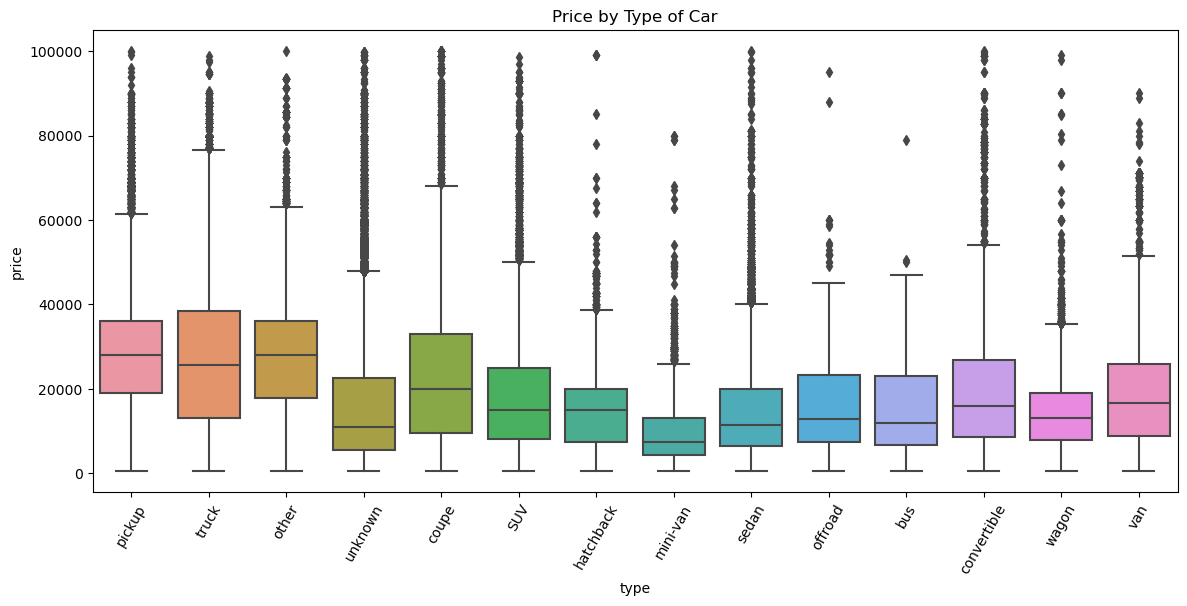

In [20]:
# See whether any useful info can be practically extracted from the 'type' column
plt.figure(figsize=(14,6))
plt.title('Price by Type of Car')
plt.xticks(rotation=60)
sns.boxplot(data=df, x=df['type'],y=df['price'])

In [21]:
# Convert type to 0/1 for non-truck vs. truck (since trucks appear to have higher prices)
truck = ['pickup','truck']
non_truck = list(df.query('type not in @truck')['type'].unique())

df['type'] = df['type'].replace(non_truck,0).replace(truck,1)

<AxesSubplot: title={'center': 'Price by Color'}, xlabel='paint_color', ylabel='price'>

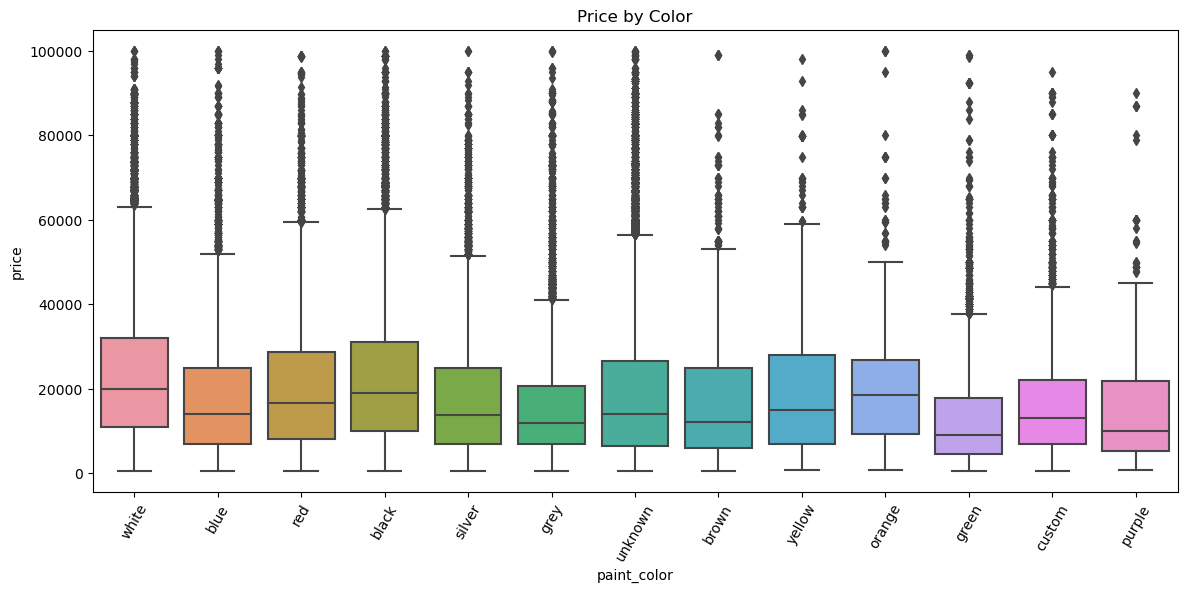

In [22]:
# See whether any useful info can be practically extracted from the color column 
plt.figure(figsize=(14,6))
plt.title('Price by Color')
plt.xticks(rotation=60)
sns.boxplot(data=df, x=df['paint_color'],y=df['price'])

In [23]:
# The colors all look pretty similar, so this column can be dropped
df = df.drop('paint_color',axis=1)

<AxesSubplot: title={'center': 'Price by Fuel Type'}, xlabel='fuel', ylabel='price'>

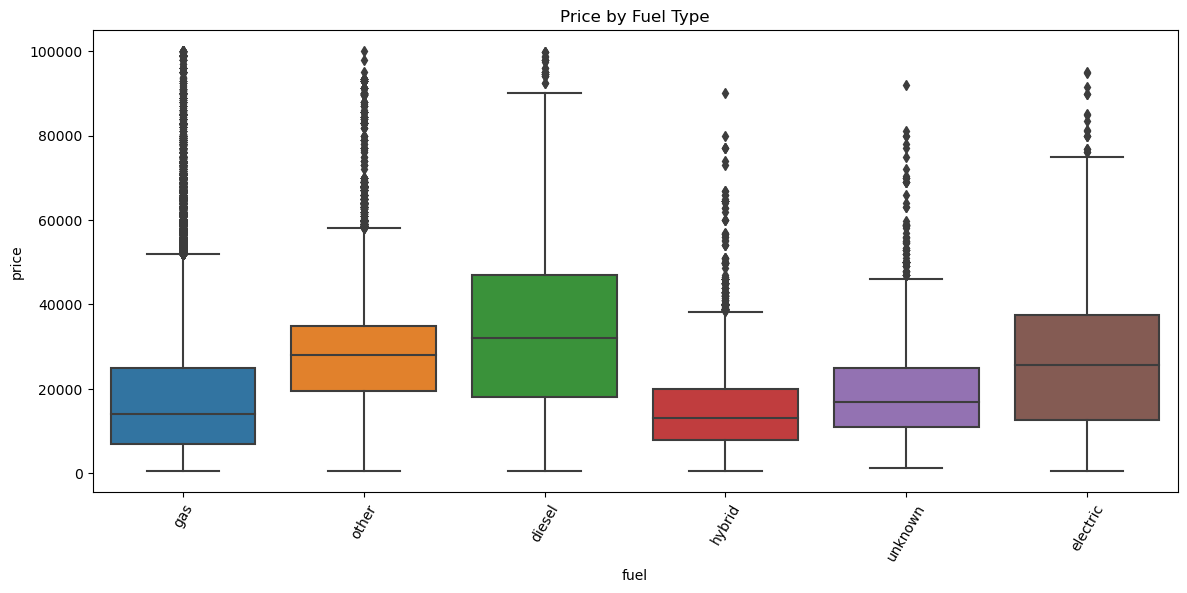

In [24]:
# See whether any useful info can be practically extracted from the fuel column 
plt.figure(figsize=(14,6))
plt.title('Price by Fuel Type')
plt.xticks(rotation=60)
sns.boxplot(data=df, x=df['fuel'],y=df['price'])

In [25]:
# While the differences here aren't huge, they are substantial enough - and there is a low enough number of categories - 
# that it is worth applying one-hot encoding to this feature 

<AxesSubplot: title={'center': 'Price by Type of Drive'}, xlabel='drive', ylabel='price'>

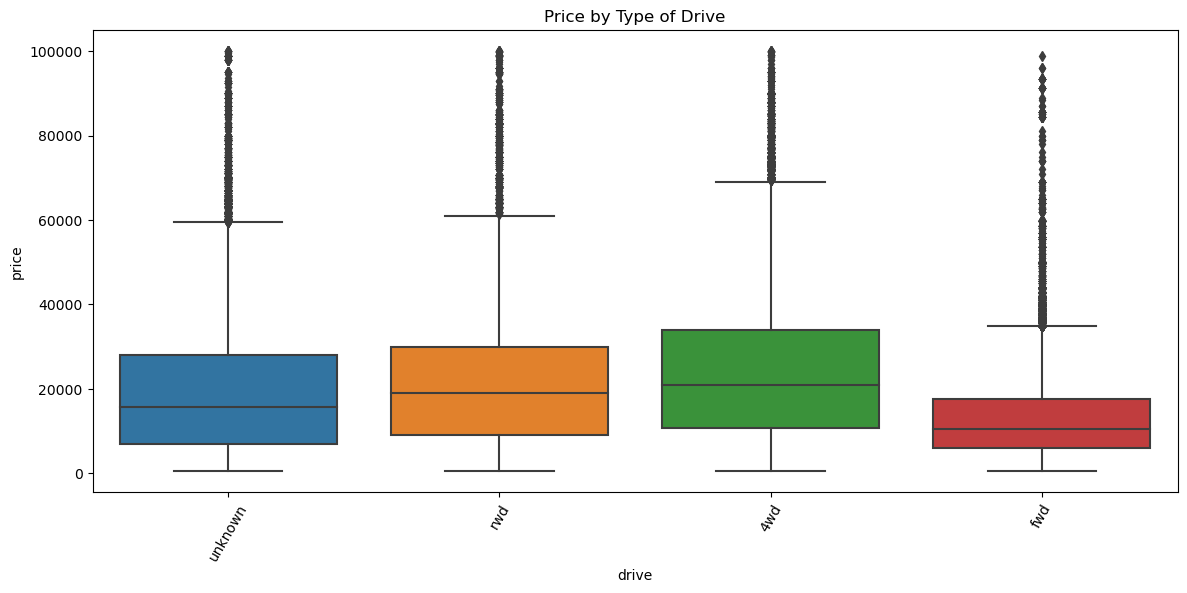

In [26]:
# See whether any useful info can be practically extracted from the drive column 
plt.figure(figsize=(14,6))
plt.title('Price by Type of Drive')
plt.xticks(rotation=60)
sns.boxplot(data=df, x=df['drive'],y=df['price'])

In [27]:
# As in the previous case, will apply one-hot encoding

<AxesSubplot: title={'center': 'Price by Type of Transmission'}, xlabel='transmission', ylabel='price'>

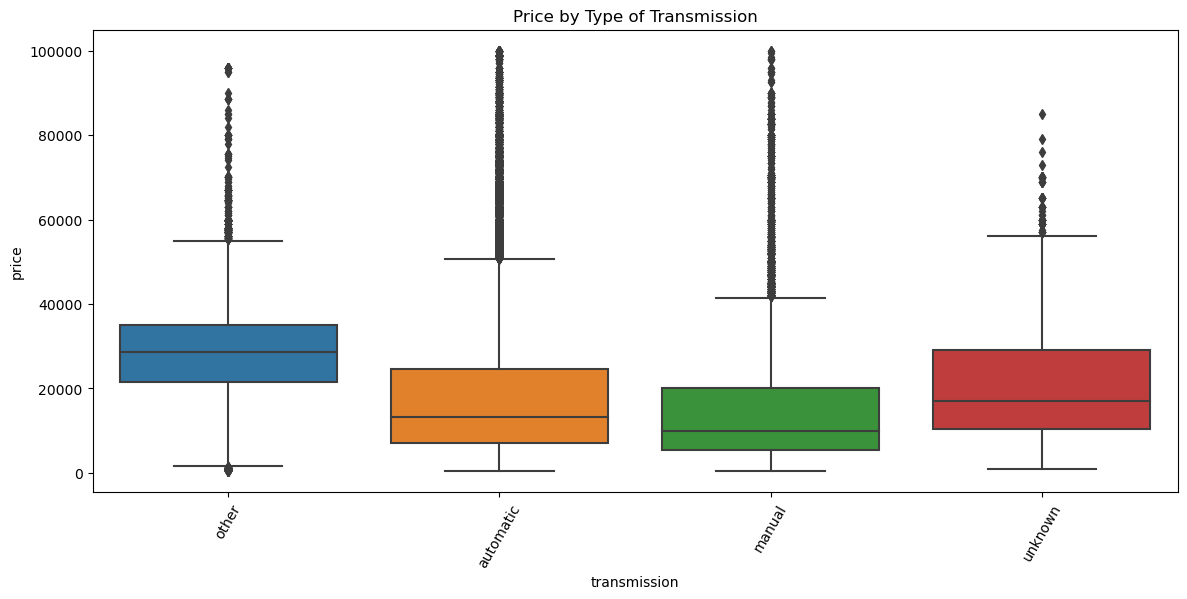

In [28]:
# See whether any useful info can be practically extracted from the transmission column 
plt.figure(figsize=(14,6))
plt.title('Price by Type of Transmission')
plt.xticks(rotation=60)
sns.boxplot(data=df, x=df['transmission'],y=df['price'])

In [29]:
# The only apparent differences here involve the 'other' or 'unknown' categories, which won't be very informative...but
# like the previous cases, these can be kept for one-hot encoding just to be sure

In [200]:
# Split into one dataframe with the features and one with the target
df_features = df.drop('price',axis=1)
df_target = df[['price']]

In [31]:
# Test to see if incorporating polynomial features improves a simple linear regression model

X_train, X_test, y_train, y_test = train_test_split(df_features[['year','cylinders','odometer']],df_target,test_size=0.3,random_state=22)
errors = []
for i in range(1,5):
    pipe = Pipeline([('poly_features',PolynomialFeatures(degree=i, include_bias=False)),
                    ('model',LinearRegression())])
    pipe.fit(X_train, y_train)
    error = mean_squared_error(pipe.predict(X_test),y_test)
    errors.append([i,error])
errors

# The evaluation metric used here is mean squared error, and the lowest error is degree=2

[[1, 154616026.33468783],
 [2, 111605757.61602534],
 [3, 127604664.23815395],
 [4, 132752945.0999281]]

In [32]:
# Set up one-hot encoding, ordinal encoding, and polynomial features
transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['transmission','drive','fuel']),
                                          (OrdinalEncoder(categories = [['salvage','fair','good','excellent','like new','new']]), ['condition']),
                                          (PolynomialFeatures(include_bias = False, degree = 2), ['year','cylinders','odometer']) ,remainder='passthrough')

In [33]:
# Apply column transformation
df_transformed = pd.DataFrame(transformer.fit_transform(df_features))
df_transformed.head()

0    1    2    3    4    5    6    7    8    9   ...        17         18  \
0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   57923.0  4056196.0   
1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   71229.0  4040100.0   
2  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   19160.0  4080400.0   
3  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   41124.0  4068289.0   
4  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  128000.0  4052169.0   

        19           20    21        22            23   24   25   26  
0  16112.0  116656922.0  64.0  463384.0  3.355074e+09  0.0  1.0  1.0  
1  16080.0  143170290.0  64.0  569832.0  5.073570e+09  0.0  1.0  1.0  
2  16160.0   38703200.0  64.0  153280.0  3.671056e+08  0.0  1.0  1.0  
3  16136.0   82947108.0  64.0  328992.0  1.691183e+09  0.0  1.0  1.0  
4  12078.0  257664000.0  36.0  768000.0  1.638400e+10  0.0  1.0  1.0  

[5 rows x 27 columns]

In [105]:
transformer.get_feature_names_out()

array(['onehotencoder__transmission_automatic',
       'onehotencoder__transmission_manual',
       'onehotencoder__transmission_other',
       'onehotencoder__transmission_unknown', 'onehotencoder__drive_4wd',
       'onehotencoder__drive_fwd', 'onehotencoder__drive_rwd',
       'onehotencoder__drive_unknown', 'onehotencoder__fuel_diesel',
       'onehotencoder__fuel_electric', 'onehotencoder__fuel_gas',
       'onehotencoder__fuel_hybrid', 'onehotencoder__fuel_other',
       'onehotencoder__fuel_unknown', 'ordinalencoder__condition',
       'polynomialfeatures__year', 'polynomialfeatures__cylinders',
       'polynomialfeatures__odometer', 'polynomialfeatures__year^2',
       'polynomialfeatures__year cylinders',
       'polynomialfeatures__year odometer',
       'polynomialfeatures__cylinders^2',
       'polynomialfeatures__cylinders odometer',
       'polynomialfeatures__odometer^2', 'remainder__manufacturer',
       'remainder__title_status', 'remainder__type'], dtype=object)

In [ ]:
# Important information for later: transmission (0-3), drive (4-7), fuel (8-13), condition (14), year (15), cylinder (16)
#  odometer (17), year^2 (18), year*cylinders (19), year*odometer (20), cylinders^2 (21), cylinders*odometer (22), 
#  odometers^2 (23), manufacturer (24), title (25), type (26)

In [34]:
# Scale the data
scaler = StandardScaler()
df_transformed = pd.DataFrame(scaler.fit_transform(df_transformed))

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df_transformed,df_target,test_size=0.3,random_state=22)

In [46]:
# First model: Ridge (with grid search for best alpha)
ridge = Ridge()
alphas = {'alpha':np.logspace(0,10,50)}
grid_ridge = GridSearchCV(estimator=ridge,param_grid=alphas,scoring='neg_mean_squared_error',cv=10)
grid_ridge.fit(X_train,y_train)
grid_ridge.best_params_

{'alpha': 1.0}

In [238]:
# Evaluation metric: mean squared error (adequate for comparing models)
mean_squared_error(grid_ridge.best_estimator_.predict(X_test),y_test)

85750943.71033634

In [42]:
# Second model: Sequential Feature Selection (with grid search for best number of features)
sfs = Pipeline([('selector',SequentialFeatureSelector(estimator=LinearRegression())),('model',LinearRegression())])
params = {'selector__n_features_to_select':[1,2,3,4,5]}
grid_sfs = GridSearchCV(estimator=sfs,param_grid=params,scoring='neg_mean_squared_error',cv=5)
grid_sfs.fit(df_transformed,df_target)
grid_sfs.best_params_

{'selector__n_features_to_select': 5}

In [237]:
# Evaluation metric: mean squared error (adequate for comparing models)
mean_squared_error(grid_sfs.best_estimator_.predict(X_test),y_test)

99101920.54907836

In [55]:
# Streamlining the grid search process by adding 5 features at a time (and testing one model at a time)
# Number of features selected = 10
sfs10 = Pipeline([('selector',SequentialFeatureSelector(estimator=LinearRegression(),n_features_to_select=10)),('model',LinearRegression())])
sfs10_model = sfs10.fit(X_train, y_train)
np.sqrt(mean_squared_error(sfs10_model.predict(X_test),y_test))

87467571.20794083

In [60]:
# Number of features selected = 15
sfs15 = Pipeline([('selector',SequentialFeatureSelector(estimator=LinearRegression(),n_features_to_select=15)),('model',LinearRegression())])
sfs15_model = sfs15.fit(X_train, y_train)
mean_squared_error(sfs15_model.predict(X_test),y_test)

85205362.58723523

In [65]:
# Number of features selected = 20
sfs20 = Pipeline([('selector',SequentialFeatureSelector(estimator=LinearRegression(),n_features_to_select=20)),('model',LinearRegression())])
sfs20_model = sfs20.fit(X_train, y_train)
mean_squared_error(sfs20_model.predict(X_test),y_test)

84998070.232143

In [67]:
# Number of features selected = 25
sfs25 = Pipeline([('selector',SequentialFeatureSelector(estimator=LinearRegression(),n_features_to_select=25)),('model',LinearRegression())])
sfs25_model = sfs25.fit(X_train, y_train)
mean_squared_error(sfs25_model.predict(X_test),y_test)

84999643.02447978

In [ ]:
# Test error keeps decreasing as more features are added, but the added value beyond 15 features is minimal  

In [68]:
# Third model: Recursive Feature Selection
rfe = Pipeline([('selector',RFE(estimator=LinearRegression())),('model',LinearRegression())])
params = {'selector__n_features_to_select':[5,10,15,20,25]}
grid_rfe = GridSearchCV(estimator=rfe,param_grid=params,scoring='neg_mean_squared_error',cv=5)
grid_rfe.fit(X_train,y_train)
grid_rfe.best_params_

{'selector__n_features_to_select': 25}

In [70]:
# Evaluation metric: mean squared error (adequate for comparing models)
mean_squared_error(grid_rfe.best_estimator_.predict(X_test),y_test)

85383225.76107371

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [103]:
# Examining the details of the Ridge model 
grid_ridge.best_estimator_.coef_

array([[-4.54579029e+02,  5.17718740e+02,  1.77468356e+02,
         1.59885929e+01,  1.26488381e+03, -1.65981329e+03,
         6.77478582e+02, -2.20533765e+02,  2.63454853e+03,
        -1.62932611e+02, -1.46492095e+03, -3.87453664e+02,
        -1.91489663e+02, -2.64131941e+02, -8.07487208e+01,
        -5.99361182e+05, -3.64608465e+04,  7.06346712e+03,
         6.03002995e+05,  4.01584863e+04, -1.33140002e+04,
        -1.23967375e+03, -2.06167885e+03,  7.38430439e+03,
         7.34360175e+02,  8.65165186e+02,  1.19777522e+03]])

In [75]:
# Examining the details of the Ridge model --> Permutation Importance
# The evaluation metric used here is r^2, which is helpful when explaining results to a non-technical audience 
scoring = ['r2']
r_multi = permutation_importance(
    grid_ridge.best_estimator_, df_transformed, df_target, n_repeats=30, random_state=32, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"    {df_transformed.columns[i]:<8}"
                  f"   {r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

r2
    18         3553.322 +/- 5.354
    15         3510.891 +/- 5.275
    19         15.756 +/- 0.022
    16         12.991 +/- 0.019
    20         1.730 +/- 0.003
    23         0.533 +/- 0.001
    17         0.489 +/- 0.001
    8          0.067 +/- 0.000
    22         0.041 +/- 0.000
    5          0.027 +/- 0.000
    10         0.020 +/- 0.000
    4          0.016 +/- 0.000
    21         0.015 +/- 0.000
    26         0.014 +/- 0.000
    25         0.007 +/- 0.000
    24         0.005 +/- 0.000
    6          0.004 +/- 0.000
    1          0.003 +/- 0.000
    0          0.002 +/- 0.000
    11         0.001 +/- 0.000
    13         0.001 +/- 0.000
    7          0.000 +/- 0.000
    12         0.000 +/- 0.000
    2          0.000 +/- 0.000
    9          0.000 +/- 0.000
    14         0.000 +/- 0.000


In [76]:
# Examining the details of the SFS model (15 features) --> Permutation Importance
# The evaluation metric used here is r^2, which is helpful when explaining results to a non-technical audience
scoring = ['r2']
r_multi = permutation_importance(
    sfs15, df_transformed, df_target, n_repeats=30, random_state=32, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"    {df_transformed.columns[i]:<8}"
                  f"   {r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

r2
    18         5127.836 +/- 7.723
    15         5092.636 +/- 7.654
    19         72.543 +/- 0.101
    16         68.752 +/- 0.099
    23         0.433 +/- 0.001
    20         0.304 +/- 0.001
    8          0.129 +/- 0.001
    5          0.073 +/- 0.000
    22         0.036 +/- 0.000
    7          0.018 +/- 0.000
    26         0.013 +/- 0.000
    25         0.007 +/- 0.000
    0          0.006 +/- 0.000
    12         0.005 +/- 0.000
    24         0.005 +/- 0.000


In [ ]:
# In both cases, the most important features, by far, were year and year^2, which is not at all surprising

Text(0, 0.5, 'Price')

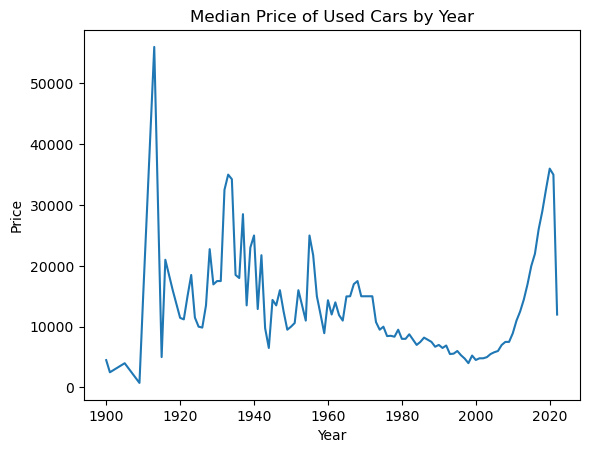

In [198]:
# Have a look at the basic relationship between year of the car and purchase price
years = sorted(df['year'].unique())
medians = df.groupby('year')['price'].median()
sns.lineplot(x=years,y=medians)
plt.title('Median Price of Used Cars by Year')
plt.xlabel('Year')
plt.ylabel('Price')

In [202]:
# There is clearly a lot of variability with older cars - small samples, some are collector's items, etc. - while a more
# dependable pattern kicks in in the mid- to late-1970s. The overwhelming majority of used cars will be from this more
# recent time frame, so it is worth focusing on that:

# Make new dataframes with fairly recent vehicles only (and leaving out the anomolous 2022 vehicles)
df_recent = df[(df['year']>1977)&(df['year']<2022)]
df_recent_features = df_recent.drop('price',axis=1)
df_recent_target = df_recent[['price']]
# Transform columns
df_recent_transformed = pd.DataFrame(transformer.fit_transform(df_recent_features))
# Scale data
df_recent_transformed = pd.DataFrame(scaler.fit_transform(df_recent_transformed))
# Train/test split
X_train_, X_test_, y_train_, y_test_ = train_test_split(df_recent_transformed,df_recent_target,test_size=0.3,random_state=22)

In [203]:
# Ridge model applied to recent cars only
grid_recent = GridSearchCV(estimator=ridge,param_grid=alphas,scoring='neg_mean_squared_error',cv=10)
grid_recent.fit(X_train_,y_train_)
grid_ridge.best_estimator_.coef_

array([[-4.54579029e+02,  5.17718740e+02,  1.77468356e+02,
         1.59885929e+01,  1.26488381e+03, -1.65981329e+03,
         6.77478582e+02, -2.20533765e+02,  2.63454853e+03,
        -1.62932611e+02, -1.46492095e+03, -3.87453664e+02,
        -1.91489663e+02, -2.64131941e+02, -8.07487208e+01,
        -5.99361182e+05, -3.64608465e+04,  7.06346712e+03,
         6.03002995e+05,  4.01584863e+04, -1.33140002e+04,
        -1.23967375e+03, -2.06167885e+03,  7.38430439e+03,
         7.34360175e+02,  8.65165186e+02,  1.19777522e+03]])

In [205]:
mean_squared_error(grid_ridge.best_estimator_.predict(X_test_),y_test_)

78955177.14832564

In [204]:
# Examining the details of the Ridge model applied to recent cars only --> Permutation Importance
# The evaluation metric used here is r^2, which is helpful when explaining results to a non-technical audience
scoring = ['r2']
r_multi = permutation_importance(
    grid_recent.best_estimator_, df_recent_transformed, df_recent_target, n_repeats=30, random_state=32, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"    {df_recent_transformed.columns[i]:<8}"
                  f"   {r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

r2
    18         3635.575 +/- 6.498
    15         3584.428 +/- 6.370
    19         250.661 +/- 0.446
    16         240.626 +/- 0.439
    20         124.778 +/- 0.130
    17         122.669 +/- 0.132
    22         0.210 +/- 0.001
    23         0.196 +/- 0.001
    8          0.070 +/- 0.000
    5          0.026 +/- 0.000
    10         0.021 +/- 0.000
    4          0.017 +/- 0.000
    26         0.014 +/- 0.000
    25         0.007 +/- 0.000
    6          0.004 +/- 0.000
    24         0.004 +/- 0.000
    1          0.003 +/- 0.000
    21         0.003 +/- 0.000
    11         0.002 +/- 0.000
    0          0.001 +/- 0.000
    13         0.001 +/- 0.000
    7          0.001 +/- 0.000
    12         0.001 +/- 0.000
    14         0.000 +/- 0.000
    9          0.000 +/- 0.000
    3          0.000 +/- 0.000


In [ ]:
# The model applied to recent cars has less test error, but it is still dominated by year and year^2 (with the 
# next most important features being the number of cylinders and the odometer reading).

# To get a better look at the role of features, it will be helpful to examine each year separately. 

In [93]:
# The year does not appear directly in the transformed dataset, but value counts info can be used to cross-reference
df['year'].value_counts()

2018    31249
2017    31037
2013    27239
2015    26821
2016    26349
        ...  
1943        1
1918        1
1915        1
1905        1
1909        1
Name: year, Length: 112, dtype: int64

In [94]:
# This shows which normalized value corresponds to each year (at least for the most common years)
df_transformed[15].value_counts()

 0.732602     31249
 0.628331     31037
 0.211246     27239
 0.419789     26821
 0.524060     26349
              ...  
-7.087742         1
-9.694523         1
-10.007337        1
-11.050049        1
-10.632964        1
Name: 15, Length: 112, dtype: int64

In [95]:
# Dataframe with 2018 cars only
df2018 = df_transformed[(df_transformed[15] > 0.732) & (df_transformed[15] < 0.733)]

In [96]:
df_target2018 = df_target.iloc[df2018.index]

In [91]:
# Ridge model for 2018 cars only
ridge18 = Ridge()
alphas = {'alpha':np.logspace(0,10,50)}
grid_ridge18 = GridSearchCV(estimator=ridge18,param_grid=alphas,scoring='neg_mean_squared_error',cv=10)
grid_ridge18.fit(df2018,df_target2018)
grid_ridge.best_params_

{'alpha': 1.0}

In [104]:
# Examining the details of the 2018 Ridge model
grid_ridge18.best_estimator_.coef_

array([[ 1.86182039e+02,  6.34177786e+02, -6.50336185e+02,
         1.45384228e+02,  1.87897746e+03, -2.46453798e+03,
         4.39241938e+02,  1.01089183e+02,  3.00179023e+03,
        -2.37378144e+02, -1.38317801e+03, -3.34525467e+02,
        -6.06184715e+02, -4.84290634e+02, -5.53273506e+02,
        -3.36274603e-19,  1.86083470e+03, -3.85163923e+03,
        -7.11024674e-19,  1.87371854e+03, -3.91735763e+03,
         7.05500397e+02, -4.90943511e+03,  4.70275455e+04,
         5.81264354e+02,  1.56016644e+03,  8.71754089e+02]])

In [92]:
# Examining the details of the 2018 Ridge model --> Permutation Importance
# The evaluation metric used here is r^2, which is helpful when explaining results to a non-technical audience
scoring = ['r2']
r_multi = permutation_importance(
    grid_ridge18.best_estimator_, df2018, df_target2018, n_repeats=30, random_state=32, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"    {df2018.columns[i]:<8}"
                  f"   {r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

r2
    5          0.082 +/- 0.002
    8          0.080 +/- 0.002
    4          0.048 +/- 0.002
    10         0.033 +/- 0.001
    19         0.031 +/- 0.001
    16         0.030 +/- 0.001
    25         0.028 +/- 0.001
    23         0.010 +/- 0.001
    2          0.010 +/- 0.001
    12         0.010 +/- 0.000
    22         0.009 +/- 0.001
    26         0.009 +/- 0.001
    24         0.007 +/- 0.000
    20         0.006 +/- 0.000
    17         0.006 +/- 0.000
    21         0.004 +/- 0.000
    13         0.003 +/- 0.000
    14         0.003 +/- 0.000
    6          0.002 +/- 0.000
    11         0.002 +/- 0.000
    1          0.001 +/- 0.000
    9          0.001 +/- 0.000
    0          0.001 +/- 0.000
    3          0.000 +/- 0.000


In [97]:
# Dataframe with 2017 cars only
df2017 = df_transformed[(df_transformed[15] > 0.628) & (df_transformed[15] < 0.629)]
df_target2017 = df_target.iloc[df2017.index]

In [98]:
# Ridge model for 2017 cars only
ridge17 = Ridge()
alphas = {'alpha':np.logspace(0,10,50)}
grid_ridge17 = GridSearchCV(estimator=ridge17,param_grid=alphas,scoring='neg_mean_squared_error',cv=10)
grid_ridge17.fit(df2017,df_target2017)
grid_ridge.best_params_

{'alpha': 1.0}

In [106]:
# Examining the details of the 2017 Ridge model 
grid_ridge17.best_estimator_.coef_

array([[ 2.81953423e+02,  4.87563529e+02, -6.37090232e+02,
        -1.03223068e+01,  1.96332898e+03, -2.29838252e+03,
         4.30169561e+02, -1.32640099e+02,  3.54734110e+03,
        -3.31493002e+02, -1.83652187e+03, -6.80062861e+02,
        -3.86155842e+02, -2.49895214e+02, -3.87429907e+02,
        -6.72107506e-22,  2.36891189e+03, -1.28788076e+03,
        -7.96823901e-21,  2.38413149e+03, -1.30920607e+03,
        -5.92004361e+02, -7.40969944e+03,  1.06388961e+04,
        -8.99192158e+01,  1.25109715e+03,  1.23716611e+03]])

In [99]:
# Examining the details of the 2017 Ridge model --> Permutation Importance
# The evaluation metric used here is r^2, which is helpful when explaining results to a non-technical audience
scoring = ['r2']
r_multi = permutation_importance(
    grid_ridge17.best_estimator_, df2017, df_target2017, n_repeats=30, random_state=32, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"    {df2017.columns[i]:<8}"
                  f"   {r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

r2
    8          0.129 +/- 0.002
    5          0.066 +/- 0.001
    22         0.063 +/- 0.001
    23         0.062 +/- 0.001
    19         0.059 +/- 0.001
    16         0.058 +/- 0.001
    4          0.051 +/- 0.001
    10         0.050 +/- 0.001
    26         0.021 +/- 0.001
    25         0.020 +/- 0.001
    11         0.008 +/- 0.000
    2          0.008 +/- 0.000
    21         0.003 +/- 0.000
    12         0.003 +/- 0.000
    20         0.002 +/- 0.000
    17         0.002 +/- 0.000
    6          0.002 +/- 0.000
    9          0.002 +/- 0.000
    14         0.002 +/- 0.000
    0          0.001 +/- 0.000
    13         0.001 +/- 0.000
    1          0.001 +/- 0.000
    7          0.000 +/- 0.000
    24         0.000 +/- 0.000


In [100]:
# Dataframe with 2016 cars only
df2016 = df_transformed[(df_transformed[15] > 0.523) & (df_transformed[15] < 0.525)]
df_target2016 = df_target.iloc[df2016.index]

In [101]:
# Ridge model for 2016 cars only
ridge16 = Ridge()
alphas = {'alpha':np.logspace(0,10,50)}
grid_ridge16 = GridSearchCV(estimator=ridge16,param_grid=alphas,scoring='neg_mean_squared_error',cv=10)
grid_ridge16.fit(df2016,df_target2016)
grid_ridge.best_params_

{'alpha': 1.0}

In [102]:
# Examining the details of the 2016 Ridge model --> Permutation Importance
# The evaluation metric used here is r^2, which is helpful when explaining results to a non-technical audience
scoring = ['r2']
r_multi = permutation_importance(
    grid_ridge16.best_estimator_, df2016, df_target2016, n_repeats=30, random_state=32, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"    {df2016.columns[i]:<8}"
                  f"   {r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

r2
    22         0.601 +/- 0.005
    23         0.211 +/- 0.003
    8          0.165 +/- 0.002
    5          0.064 +/- 0.001
    10         0.048 +/- 0.001
    4          0.039 +/- 0.001
    19         0.038 +/- 0.001
    16         0.037 +/- 0.001
    21         0.020 +/- 0.001
    26         0.018 +/- 0.001
    25         0.015 +/- 0.001
    20         0.009 +/- 0.001
    17         0.009 +/- 0.001
    6          0.008 +/- 0.001
    1          0.007 +/- 0.001
    2          0.005 +/- 0.000
    24         0.002 +/- 0.000
    13         0.002 +/- 0.000
    14         0.002 +/- 0.000
    12         0.002 +/- 0.000
    7          0.001 +/- 0.000
    11         0.001 +/- 0.000
    9          0.001 +/- 0.000
    0          0.000 +/- 0.000
    3          0.000 +/- 0.000


In [ ]:
# In these year-specific models, the most important features are generally:
# Diesel (positive)
# Gas (negative)
# 4-Wheel Drive (positive)
# Front-Wheel Drive (negative)
# More cylinders (positive)

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

**--------------------------------------------------------------------**

**This analysis of used car prices has the following primary findings:** 

**(1) The most important determinant of a used car's price, by far, is its year of manufacture. While this isn't surprising in the least, it is worth noting that the relationship is not a simple linear one - a used car's price can be predicted most effectively by incorporating both the year of the car and the year _squared_ (which helps to capture the curved nature of the relationship).** 

**As can be seen in the graph below, the relationship between year and price is especially complicated when older vehicles - those made before the 1970s - are included. There is a great deal of variability in the price of older cars, in part simply because there are fewer of them (and smaller samples generate less dependable patterns), and in part, presumably, because some are very high-priced collector's items. Since more recent cars (1970s on) make up the overwhelming majority of used car purchases, the remainder of the analysis will focus on them.**

**--------------------------------------------------------------------**

/tmp/ipykernel_5719/22750904.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  medians = df.groupby('year')['price'].median()[:-1]


Text(0, 0.5, 'Price')

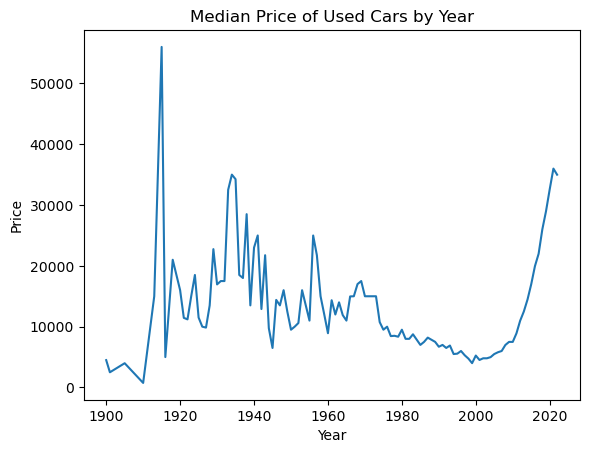

In [217]:
# Show the relationship between year of the car and purchase price
years = sorted(df['year'].unique()[:-1])
medians = df.groupby('year')['price'].median()[:-1]
sns.lineplot(x=years,y=medians)
plt.title('Median Price of Used Cars by Year')
plt.xlabel('Year')
plt.ylabel('Price')

**--------------------------------------------------------------------**

**As noted above, all subsequent findings relate to more recent used cars (1970s on) only,** 

**(2) When the year of the car is held fixed, the features that most help to predict a car's price are as follows: the number of cylinders in the engine (more cylinders --> higher price), the type of fuel used (diesel --> higher price, gas --> lower price), the type of drivetrain (4-wheel drive --> higher price, front-wheel drive --> lower price), and the odometer reading (lower odometer --> higher price).** 

**(3) Another pattern that can be seen is that trucks tend to sell for higher prices than other types of vehicles, but I believe this can be largely or even wholly explained by the differences listed above - that is, trucks tend to have more cylinders, they more frequently run on diesel fuel, and they more frequently have 4-wheel drive. But these factors are positively associated with higher prices on other vehicles as well as trucks, so they appear to be attractive in their own right (and are presumably part of what draws people to purchasing trucks).** 

**The graph below shows the association between the number of cylinders in the engine and price. (There are very few vehicles with 12 cylinders, which results in a lot of fluctuation/variability in that category, but the general pattern can still be clearly seen). The scale of the observed price differences is on the order of 10-30,000 dollars, on average.**

**--------------------------------------------------------------------**

In [225]:
df_12c = df[(df['cylinders']==12)&(df['year']>1977)&(df['year']<2022)]
df_10c = df[(df['cylinders']==10)&(df['year']>1977)&(df['year']<2022)]
df_8c = df[(df['cylinders']==8)&(df['year']>1977)&(df['year']<2022)]
df_6c = df[(df['cylinders']==6)&(df['year']>1977)&(df['year']<2022)]
df_5c = df[(df['cylinders']==5)&(df['year']>1977)&(df['year']<2022)]
df_4c = df[(df['cylinders']==4)&(df['year']>1977)&(df['year']<2022)]
df_3c = df[(df['cylinders']==3)&(df['year']>1977)&(df['year']<2022)]
median_12c = df_12c.groupby('year')['price'].median()
median_10c = df_10c.groupby('year')['price'].median()
median_8c = df_8c.groupby('year')['price'].median()
median_6c = df_6c.groupby('year')['price'].median()
median_5c = df_5c.groupby('year')['price'].median()
median_4c = df_4c.groupby('year')['price'].median()
median_3c = df_3c.groupby('year')['price'].median()
years_12c = sorted(df_12c['year'].unique())
years_10c = sorted(df_10c['year'].unique())
years_8c = sorted(df_8c['year'].unique())
years_6c = sorted(df_6c['year'].unique())
years_5c = sorted(df_5c['year'].unique())
years_4c = sorted(df_4c['year'].unique())
years_3c = sorted(df_3c['year'].unique())

Text(0, 0.5, 'Price')

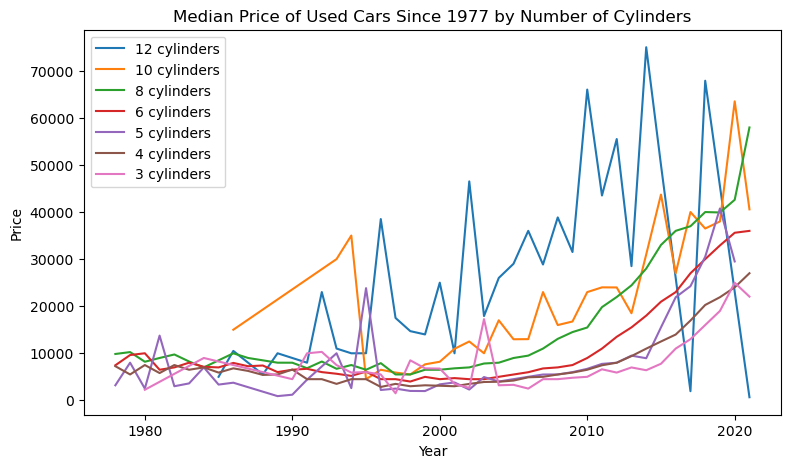

In [226]:
fig5,ax5 = plt.subplots(figsize=(9,5))
sns.lineplot(x=years_12c,y=median_12c,label='12 cylinders',ax=ax5)
sns.lineplot(x=years_10c,y=median_10c,label='10 cylinders',ax=ax5)
sns.lineplot(x=years_8c,y=median_8c,label='8 cylinders',ax=ax5)
sns.lineplot(x=years_6c,y=median_6c,label='6 cylinders',ax=ax5)
sns.lineplot(x=years_5c,y=median_5c,label='5 cylinders',ax=ax5)
sns.lineplot(x=years_4c,y=median_4c,label='4 cylinders',ax=ax5)
sns.lineplot(x=years_3c,y=median_3c,label='3 cylinders',ax=ax5)
plt.title('Median Price of Used Cars Since 1977 by Number of Cylinders')
plt.xlabel('Year')
plt.ylabel('Price')

**--------------------------------------------------------------------**

**The next graph shows the association between type of fuel and price. The scale of the observed price differences is on the order of 10-30,000 dollars, on average.**

**Below that, the data is broken down between trucks and other kinds of vehicle, showing the independent effect of diesel vs. gas. The scale of the observed price differences remains on the order of 10-30,000 dollars, on average, within each subcategory.**

**--------------------------------------------------------------------**

In [144]:
# Focusing on fairly recent cars (since 1977), show consistent advantage for diesel over gas
df_diesel = df[(df['fuel']=='diesel')&(df['year']>1977)&(df['year']<2022)]
df_gas = df[(df['fuel']=='gas')&(df['year']>1977)&(df['year']<2022)]
median_diesel = df_diesel.groupby('year')['price'].median()
median_gas = df_gas.groupby('year')['price'].median()
years_diesel = sorted(df_diesel['year'].unique())
years_gas = sorted(df_gas['year'].unique())

Text(0, 0.5, 'Price')

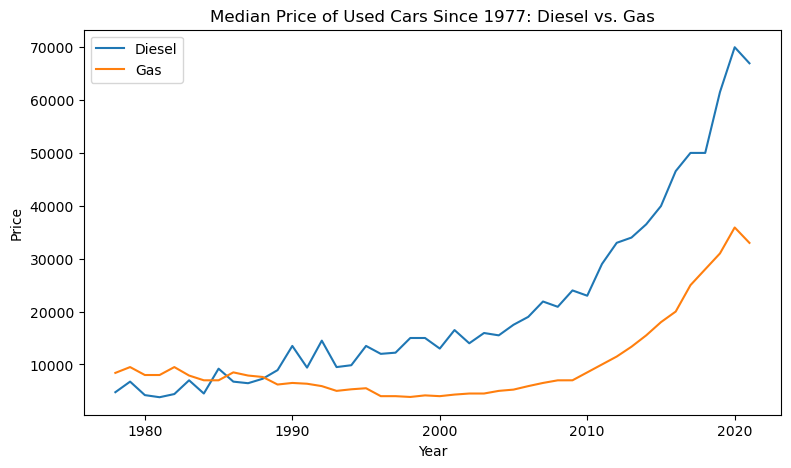

In [190]:
fig,ax = plt.subplots(figsize=(9,5))
sns.lineplot(x=years_diesel,y=median_diesel,label='Diesel',ax=ax)
sns.lineplot(x=years_gas,y=median_gas,label='Gas',ax=ax)
plt.title('Median Price of Used Cars Since 1977: Diesel vs. Gas')
plt.xlabel('Year')
plt.ylabel('Price')

In [182]:
# Show that the advantage for diesel seems to be independent of car vs. truck...so the advantage for trucks may simply
# be an artifact of the fact that they run on diesel more frequently (consistent with the permutation importance results)
df_diesel_truck = df[(df['type']==1)&(df['fuel']=='diesel')&(df['year']>1977)&(df['year']<2022)]
df_gas_truck = df[(df['type']==1)&(df['fuel']=='gas')&(df['year']>1977)&(df['year']<2022)]
df_diesel_other = df[(df['type']==0)&(df['fuel']=='diesel')&(df['year']>1977)&(df['year']<2022)]
df_gas_other = df[(df['type']==0)&(df['fuel']=='gas')&(df['year']>1977)&(df['year']<2022)]
median_diesel_truck = df_diesel_truck.groupby('year')['price'].median()
median_gas_truck = df_gas_truck.groupby('year')['price'].median()
median_diesel_other = df_diesel_other.groupby('year')['price'].median()
median_gas_other = df_gas_other.groupby('year')['price'].median()
years_diesel_truck = sorted(df_diesel_truck['year'].unique())
years_gas_truck = sorted(df_gas_truck['year'].unique())
years_diesel_other = sorted(df_diesel_other['year'].unique())
years_gas_other = sorted(df_gas_other['year'].unique())

Text(0, 0.5, 'Price')

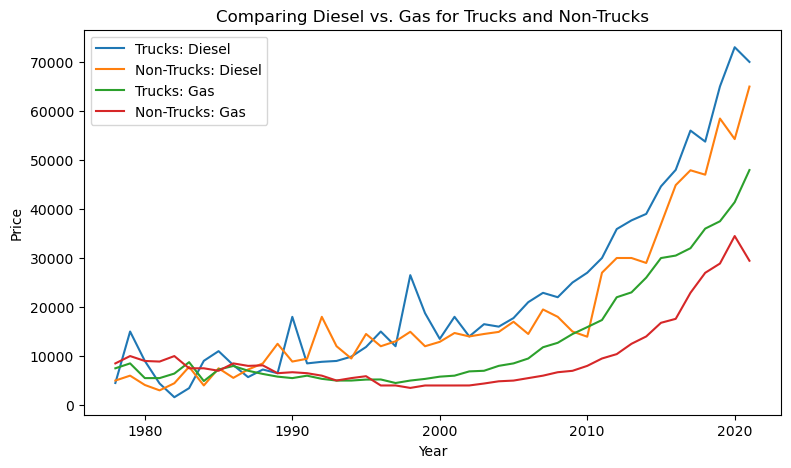

In [193]:
fig3,ax3 = plt.subplots(figsize=(9,5))
sns.lineplot(x=years_diesel_truck,y=median_diesel_truck,label='Trucks: Diesel',ax=ax3)
sns.lineplot(x=years_diesel_other,y=median_diesel_other,label='Non-Trucks: Diesel',ax=ax3)
sns.lineplot(x=years_gas_truck,y=median_gas_truck,label='Trucks: Gas',ax=ax3)
sns.lineplot(x=years_gas_other,y=median_gas_other,label='Non-Trucks: Gas',ax=ax3)
plt.title('Comparing Diesel vs. Gas for Trucks and Non-Trucks')
plt.xlabel('Year')
plt.ylabel('Price')

**--------------------------------------------------------------------**

**The next graph shows the association between type of drivetrain and price. The scale of the observed price differences is on the order of 5-20,000 dollars, on average.**

**Below that, the data is broken down between trucks and other kinds of vehicle, showing the apparent independent effect of 4-wheel drive vs. front-wheel drive. Note, though, that the effect in this case is a good bit smaller than in the case of diesel vs. gas. The scale of the observed price differences drops to on the order of 3-10,000 dollars, on average, within each subcategory.**

**--------------------------------------------------------------------**

In [158]:
# Focusing on fairly recent cars (since 1977), show consistent advantage for 4-wheel drive over front-wheel drive
df_4wd = df[(df['drive']=='4wd')&(df['year']>1977)&(df['year']<2022)]
df_fwd = df[(df['drive']=='fwd')&(df['year']>1977)&(df['year']<2022)]
median_4wd = df_4wd.groupby('year')['price'].median()
median_fwd = df_fwd.groupby('year')['price'].median()
years_4wd = sorted(df_4wd['year'].unique())
years_fwd = sorted(df_fwd['year'].unique())

Text(0, 0.5, 'Price')

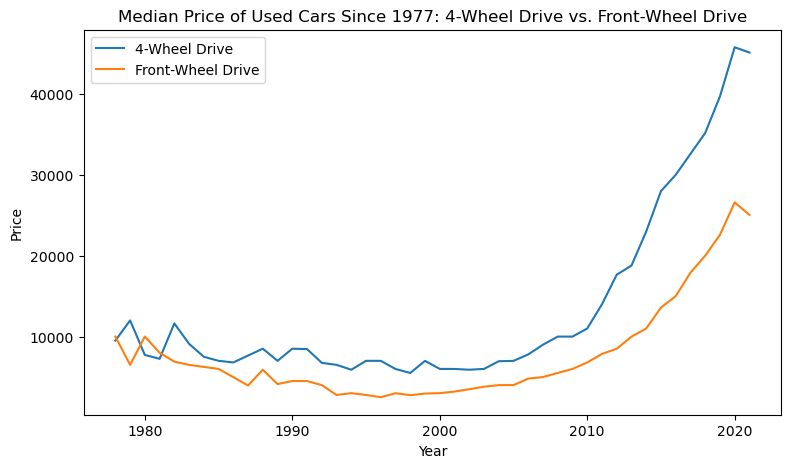

In [191]:
fig1,ax1 = plt.subplots(figsize=(9,5))
sns.lineplot(x=years_4wd,y=median_4wd,label='4-Wheel Drive',ax=ax1)
sns.lineplot(x=years_fwd,y=median_fwd,label='Front-Wheel Drive',ax=ax1)
plt.title('Median Price of Used Cars Since 1977: 4-Wheel Drive vs. Front-Wheel Drive')
plt.xlabel('Year')
plt.ylabel('Price')

In [187]:
# Show that the advantage for 4-wheel drive seems to be independent of car vs. truck...so the advantage for trucks may simply
# be an artifact of the fact that they are more frequently 4-wheel drive (consistent with the permutation importance results)
df_4wd_truck = df[(df['type']==1)&(df['drive']=='4wd')&(df['year']>1977)&(df['year']<2022)]
df_fwd_truck = df[(df['type']==1)&(df['drive']=='fwd')&(df['year']>1977)&(df['year']<2022)]
df_4wd_other = df[(df['type']==0)&(df['drive']=='4wd')&(df['year']>1977)&(df['year']<2022)]
df_fwd_other = df[(df['type']==0)&(df['drive']=='fwd')&(df['year']>1977)&(df['year']<2022)]
median_4wd_truck = df_4wd_truck.groupby('year')['price'].median()
median_fwd_truck = df_fwd_truck.groupby('year')['price'].median()
median_4wd_other = df_4wd_other.groupby('year')['price'].median()
median_fwd_other = df_fwd_other.groupby('year')['price'].median()
years_4wd_truck = sorted(df_4wd_truck['year'].unique())
years_fwd_truck = sorted(df_fwd_truck['year'].unique())
years_4wd_other = sorted(df_4wd_other['year'].unique())
years_fwd_other = sorted(df_fwd_other['year'].unique())

Text(0, 0.5, 'Price')

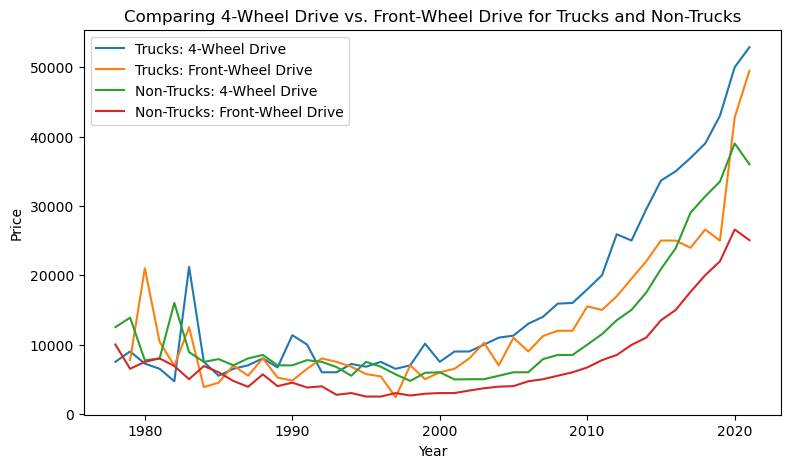

In [195]:
fig4,ax4 = plt.subplots(figsize=(9,5))
sns.lineplot(x=years_4wd_truck,y=median_4wd_truck,label='Trucks: 4-Wheel Drive',ax=ax4)
sns.lineplot(x=years_fwd_truck,y=median_fwd_truck,label='Trucks: Front-Wheel Drive',ax=ax4)
sns.lineplot(x=years_4wd_other,y=median_4wd_other,label='Non-Trucks: 4-Wheel Drive',ax=ax4)
sns.lineplot(x=years_fwd_other,y=median_fwd_other,label='Non-Trucks: Front-Wheel Drive',ax=ax4)
plt.title('Comparing 4-Wheel Drive vs. Front-Wheel Drive for Trucks and Non-Trucks')
plt.xlabel('Year')
plt.ylabel('Price')

**--------------------------------------------------------------------**

**The next graph shows the association between trucks and higher prices. The scale of the observed price differences is on the order of 5-15,000 dollars, on average. And as noted above, it is likely that this association can be explained in terms of those discussed above.**

**--------------------------------------------------------------------**

In [164]:
# Focusing on fairly recent cars (since 1977), show consistent advantage for trucks over other vehicles
df_truck = df[(df['type']==1)&(df['year']>1977)&(df['year']<2022)]
df_not = df[(df['type']==0)&(df['year']>1977)&(df['year']<2022)]
median_truck = df_truck.groupby('year')['price'].median()
median_not = df_not.groupby('year')['price'].median()
years_truck = sorted(df_truck['year'].unique())
years_not = sorted(df_not['year'].unique())

Text(0, 0.5, 'Price')

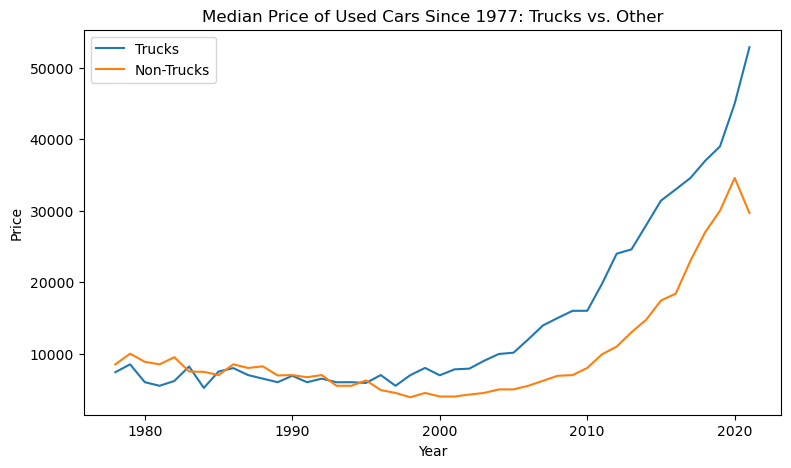

In [192]:
fig2,ax2 = plt.subplots(figsize=(9,5))
sns.lineplot(x=years_truck,y=median_truck,label='Trucks',ax=ax2)
sns.lineplot(x=years_not,y=median_not,label='Non-Trucks',ax=ax2)
plt.title('Median Price of Used Cars Since 1977: Trucks vs. Other')
plt.xlabel('Year')
plt.ylabel('Price')

**--------------------------------------------------------------------**

**Finally, the next graph shows the association between lower odometer readings (i.e. fewer miles) and higher prices. The scale of the observed price differences is on the order of 2-5,000 dollars, on average.**

**Note that this is a fairly crude comparison between vehicles that have below average odometer readings for their year and vehicles that have above average odometer readings for their year. Readings that are well below or well above average are likely to have more pronounced effects on price.**

**--------------------------------------------------------------------**

In [206]:
df_recent['median odometer'] = df_recent.groupby('year')['odometer'].transform('median')
df_odo_above = df_recent[df_recent['odometer']>=df_recent['median odometer']]
df_odo_below = df_recent[df_recent['odometer']<df_recent['median odometer']]

/tmp/ipykernel_5719/1485692025.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recent['median odometer'] = df_recent.groupby('year')['odometer'].transform('median')


In [207]:
recent_median = df_recent.groupby('year')['price'].median()
above_median = df_odo_above.groupby('year')['price'].median()
below_median = df_odo_below.groupby('year')['price'].median()
years_recent = sorted(df_recent['year'].unique())
years_above = sorted(df_odo_above['year'].unique())
years_below = sorted(df_odo_below['year'].unique())

Text(0, 0.5, 'Price')

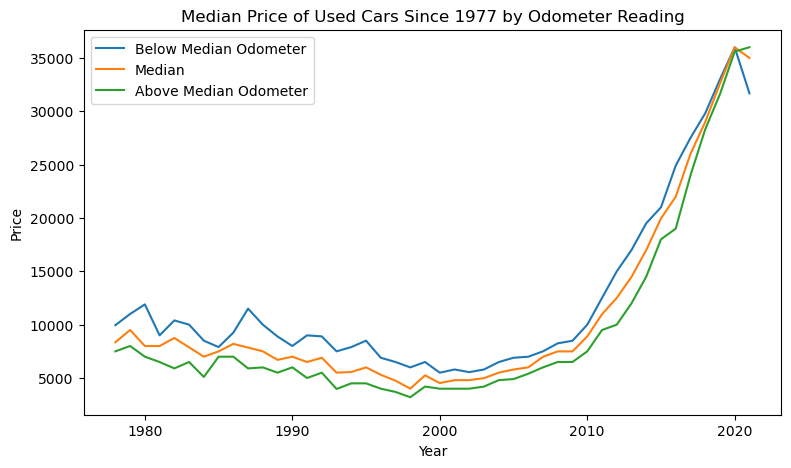

In [209]:
fig6,ax6 = plt.subplots(figsize=(9,5))
sns.lineplot(x=years_below,y=below_median,label='Below Median Odometer',ax=ax6)
sns.lineplot(x=years_recent,y=recent_median,label='Median',ax=ax6)
sns.lineplot(x=years_above,y=above_median,label='Above Median Odometer',ax=ax6)
plt.title('Median Price of Used Cars Since 1977 by Odometer Reading')
plt.xlabel('Year')
plt.ylabel('Price')

**--------------------------------------------------------------------**

**Next steps and recommendations**

**Based on this analysis, the best way to obtain a higher average sale price would be to increase the share of _newer_ cars in the inventory. Further benefit would come from increasing the share of (in order of importance) vehicles with a high number of cylinders in the engine, diesel vehicles, 4-wheel drive vehicles, and vehicles that have been driven for a lower-than-average number of miles (for the year of manufacture).**

**Of course, increasing the average sale price alone is not the main goal. It is also important to factor in a vehicle's likely _acquisition costs_ and likely _speed of sale_. The year of manufacture, for instance, is so widely known as a key driver of sale price that it is almost surely reflected in the acquisition costs. So the crucial next step is to examine these other factors - acquisition costs and speed of sale - in order to learn about the key drivers of _profitability_ in used car sales. The ultimate goal is to gain additional margin by favoring vehicle features that drive higher sale prices without driving proportionally higher acquisition costs.** 

**--------------------------------------------------------------------**